In [2]:
from NuPyCEE import omega as o
from JINAPyCEE import omega_plus as op
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

In [3]:
# Calculate the total mass of gas in the CGM as a function of time
def get_CGM_mass(inst):
    m_CGM_temp = np.zeros(inst.inner.nb_timesteps+1)
    for i_t in range(inst.inner.nb_timesteps+1):
        m_CGM_temp[i_t] = sum(inst.ymgal_outer[i_t])
    return m_CGM_temp

# Dark Matter Evolution

In [4]:
m_DM_0=1e12

In [5]:
# Run an omega model for DM evolution
o_DM = o.omega(m_DM_0=m_DM_0, DM_evolution=True)

# Convert the evolution of the dark matter mass into an input array
# The timestepping of this input array does not need the same as OMEGA+
# DM_array[ time ][ mass]
DM_array = [None] * (o_DM.nb_timesteps+1)
for i_t in range(o_DM.nb_timesteps+1):
    DM_array[i_t] = [o_DM.history.age[i_t], o_DM.m_DM_t[i_t]]

OMEGA run in progress..
..Time refinement..
   OMEGA run completed - Run time: 1.21s


# Model Setup

In [6]:
# exp_ml describes the dependence of outflow mass loading on DM mass (gets divided by 3) & z (divided by 2)
# redshift_f is final redshift
DM_evolution = {'DM_array':DM_array,
                'DM_outflow_C17':True,
                'C17_eta_z_dep':True,
                'redshift_f':0.0,
                'exp_ml':3 # can change
               }

# exp_infall, t_inflow, f_f_ff, and m_inflow_in are mutually exclusive
# f_t_ff describes gas infall timescale as a fraction of free-fall time (=1.0, instant cooling)
inflow = {#'exp_infall':[[100/2.2, 0.0, 0.68e9], [13.0/2.2, 1.0e9, 7.0e9]],
          #'t_inflow':1e9,
          'f_t_ff':10, # no touchy plz
         }

# IMPORTANT NOTE: By default, only stars between 1 and 30 Msun will eject yields.
# Stars above and below this limit will eject nothing.
# You can change this assumption with the "imf_yields_range" option
yields = {#"table":'yield_tables/agb_and_massive_stars_K10_K06_0.5HNe.txt',
          "imf_yields_range":[1,30]}

# t_star will override f_dyn
# with DM_evolution, mass_loading references late-time
sf_fb = {#'f_dyn':0.1, # doesn't form stars??
         "t_star":1,
         'mass_loading':2,
         'sfe':5e-10,
         'sfe_m_dep':False,
         'sfe_m_index':-0.5,
         'imf_type':'chabrier', # default
         'imf_bdys':[0.1,100.], # default
        }

In [7]:
# mgal is initial mass
# mass_loading corresponds to end of sim when using time- and redshift- dependence
test = op.omega_plus(mgal=1.0, m_DM_0=m_DM_0,
                     **sf_fb,
                     **yields,
                     **inflow,
                     **DM_evolution,
                     Grackle_on=True, special_timesteps=150
                    )

OMEGA+ run in progress..
OMEGA run in progress..
   OMEGA+ run completed - Run time: 3.5s


Text(0, 0.5, 'Mass [Msun]')

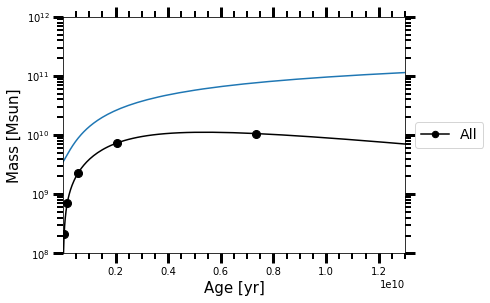

In [8]:
test.inner.plot_totmasses()
plt.plot(test.inner.history.age, get_CGM_mass(test))

plt.xscale('linear')
plt.xlabel('Age [yr]')

plt.ylim(1e8,1e12)
plt.ylabel('Mass [Msun]')

# Milky Way Diagnostics

In [9]:
# OMEGA+ time array
t_op = np.array(test.inner.history.age)/1.0e9

# Get the inflow rates [Msun/yr]
inflow_rate_exp = test.inner.m_inflow_t/test.inner.history.timesteps

# Get the total mass of gas [Msun]
m_gas_exp = np.zeros(test.inner.nb_timesteps+1)
for i_t in range(test.inner.nb_timesteps+1):
    m_gas_exp[i_t] = sum(test.inner.ymgal[i_t])
    
# Get the total mass lost by stars [Msun]
m_star_lost = 0.0
for i_t in range(test.inner.nb_timesteps):
    m_star_lost += np.sum(test.inner.mdot[i_t])
    
# Get the CC and Ia SNe rates [yr^-1]
cc_sne_rate = test.inner.history.sn2_numbers[1:]/test.inner.history.timesteps
Ia_sne_rate = test.inner.history.sn1a_numbers[1:]/test.inner.history.timesteps

# Stellar mass [Msun] .. corrected for stellar mass loss
print('Current stellar mass =','%.2E' %(np.sum(test.inner.history.m_locked)-m_star_lost), 'Msun')

Current stellar mass = 3.58E+10 Msun


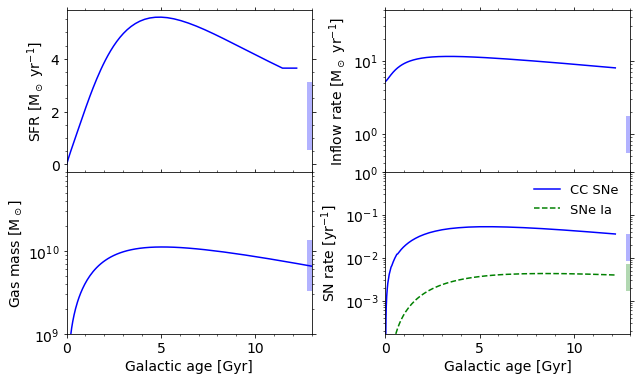

In [10]:
# Figure frame
#%matplotlib nbagg
al_f = 14 # text font
#matplotlib.rcParams.update({'font.size': 14.})
f, axarr = plt.subplots(2, 2, figsize=(9,6), sharex=True, sharey=False) # [row][col]
f.subplots_adjust(hspace=0.)
f.subplots_adjust(wspace=0.3)

# Plot SFR
axarr[0][0].plot([12.9,12.9], [0.65,3.0], linewidth=6, color='b', alpha=0.3)
axarr[0][0].plot(t_op[:-1], test.inner.history.sfr_abs[:-1], '-b', linewidth=1.5)

# Plot inflows
axarr[0][1].plot([12.9,12.9], [0.6,1.6], linewidth=6, color='b', alpha=0.3)
axarr[0][1].plot(t_op[:-1], inflow_rate_exp, '-b', linewidth=1.5)

# Plot gas mass
axarr[1][0].plot([12.9,12.9], [3.6e9,12.6e9], linewidth=6, color='b', alpha=0.3)
axarr[1][0].plot(t_op, m_gas_exp, '-b', linewidth=1.5)

# Plot SNe rates
axarr[1][1].plot([12.9,12.9], [1e-2,3e-2], linewidth=6, color='b', alpha=0.3)
axarr[1][1].plot([12.9,12.9], [0.2e-2,0.6e-2], linewidth=6, color='g', alpha=0.3)
axarr[1][1].plot(t_op[:-1], cc_sne_rate, '-b', linewidth=1.5, label='CC SNe')
axarr[1][1].plot(t_op[:-1], Ia_sne_rate, '--g', linewidth=1.5, label='SNe Ia')
axarr[1][1].legend(frameon=False, fontsize=13)
    
    
# Y-axis
axarr[0][0].set_ylabel('SFR [M$_\odot$ yr$^{-1}$]', fontsize=al_f)
axarr[0][1].set_ylabel('Inflow rate [M$_\odot$ yr$^{-1}$]', fontsize=al_f)
axarr[0][1].set_yscale('log')
axarr[0][1].set_ylim(3e-1,5e1)
axarr[1][0].set_ylabel('Gas mass [M$_\odot$]', fontsize=al_f)
axarr[1][0].set_yscale('log')
axarr[1][0].set_ylim(1e9,9e10)
axarr[1][1].set_ylabel('SN rate [yr$^{-1}$]', fontsize=al_f)
axarr[1][1].set_yscale('log')
axarr[1][1].set_ylim(1.7e-4,1e0)

# X-axis
axarr[1][0].set_xlabel('Galactic age [Gyr]', fontsize=al_f)
axarr[1][1].set_xlabel('Galactic age [Gyr]', fontsize=al_f)
axarr[1][1].set_xlim(0,13)

# Adjust layout/white spaces
plt.subplots_adjust(top=0.95)
plt.subplots_adjust(bottom=0.2)
plt.subplots_adjust(left=0.1)
plt.subplots_adjust(right=0.97)

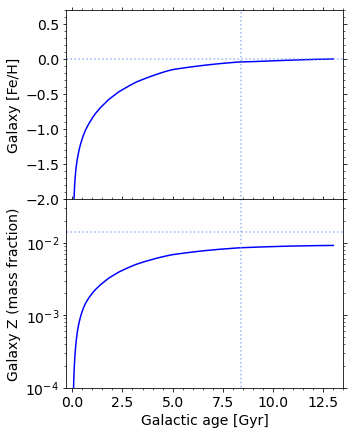

In [11]:
# Plot the age-metallicity relations
al_f = 14 # text font
#matplotlib.rcParams.update({'font.size': 14.})
f, ax = plt.subplots(2,1, figsize=(5,7), sharex=True)
f.subplots_adjust(hspace=0)

# Extract predictions
o_t, o_Fe_H = test.inner.plot_spectro(solar_norm='Asplund_et_al_2009', return_x_y=True)

# Plot age-[Fe/H]
# ===============
#ax[0].plot(13.-(np.array(t)), FeH, 'o', color='cornflowerblue', markersize=3, alpha=0.7)

ax[0].plot(np.array(o_t)/1e9, o_Fe_H, '-b', linewidth=1.5)

ax[0].plot([(13-4.6),(13-4.6)], [-10, 10], ':', color='cornflowerblue', alpha=0.7)
ax[0].plot([-1e10,1e10], [0,0], ':', color='cornflowerblue', alpha=0.7)
ax[0].set_xlim(-0.3,13.5)
ax[0].set_ylim(-2., 0.7)

# Plot age-Z
# ==========
ax[1].plot(np.array(test.inner.history.age)/1e9, test.inner.history.metallicity, '-b', linewidth=1.5)

ax[1].plot([(13-4.6),(13-4.6)], [-10, 10], ':', color='cornflowerblue', alpha=0.7)
ax[1].plot([-1e10,1e10], [0.014,0.014], ':', color='cornflowerblue', alpha=0.7)
ax[1].set_yscale('log')
ax[1].set_xlim(-0.3,13.5)
ax[1].set_ylim(1e-4, 4e-2)

# Labels and visual aspect
#ax[0].legend(fontsize=16, loc=4, frameon=False)
ax[0].set_ylabel('Galaxy [Fe/H]', fontsize=al_f)
ax[1].set_ylabel('Galaxy Z (mass fraction)', fontsize=al_f)
ax[1].set_xlabel('Galactic age [Gyr]', fontsize=al_f)

# Adjust layout/white spaces
plt.subplots_adjust(top=0.95)
plt.subplots_adjust(bottom=0.2)
plt.subplots_adjust(left=0.2)
plt.subplots_adjust(right=0.97)

No handles with labels found to put in legend.


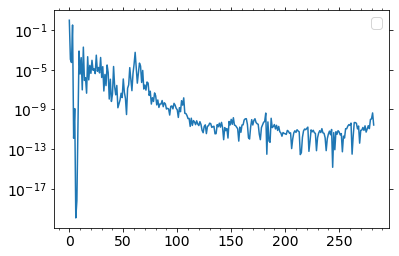

In [12]:
plt.semilogy(test.ymgal_outer[-1]/test.ymgal_outer[-1][0])
plt.legend()

In [18]:
test.ymgal_outer[-1][5]/test.ymgal_outer[-1][0]

1.1929737345904174e-09

# Fit DM Evolution

In [109]:
def tanh(x, x0, y0, k1, k2):
    return (y0+k1) + k1*np.tanh(k2*(x-x0))

[ 9.22995756 10.34229018  0.95413284  1.03287417] 10.349223074893784


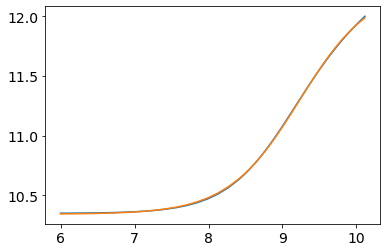

In [182]:
popt, pcov = curve_fit(tanh, np.log10(DM_arr[1:,0]), np.log10(DM_arr[1:,1]), p0=[9.3, 11.3, 1, 1])
plt.plot(np.log10(DM_arr[1:,0]), np.log10(DM_arr[1:,1]))
plt.plot(np.log10(DM_arr[1:,0]), tanh(np.log10(DM_arr[1:,0]), *popt))
print(popt, np.log10(DM_arr[0,1]))

In [406]:
# Randomly select horizontal offset and steepness adjustments
# baseline is popt
x0_add = np.random.uniform(-0.5, 0.5)
k2_mult = np.random.uniform(0.5, 2.0)

# Adjust k2 multiplier (steepness of transition) so that the LHS is close to target
while (tanh(6, popt[0]+x0_add, popt[1], popt[2]*k1_mult, popt[3]*k2_mult) - popt[1])/popt[1] > 0.001:
    print("Adjusting k2 multiplier")
    k2_mult += 0.1

# Adjust k1 multiplier (vertical stretch) so that RHS is close to target
k1_mult = 1
rhs_err = (tanh(np.log10(1.3e10), popt[0]+x0_add, popt[1], popt[2]*k1_mult, popt[3]*k2_mult) - 12)/12
while np.abs(rhs_err) > 0.001:
    print("Adjusting k1 multiplier")
    if rhs_err > 0: # overshooting
        k1_mult *= 0.9
    elif rhs_err < 0: # undershooting
        k1_mult *= 1.1
    rhs_err = (tanh(np.log10(1.3e10), popt[0]+x0_add, popt[1], popt[2]*k1_mult, popt[3]*k2_mult) - 12)/12
    
# be looser re: LHS requirement now that I've fiddled with the function params a bunch
assert np.abs(tanh(6,                popt[0]+x0_add, popt[1], popt[2]*k1_mult, popt[3]*k2_mult) - popt[1])/popt[1] < 0.01
assert np.abs(tanh(np.log10(1.3e10), popt[0]+x0_add, popt[1], popt[2]*k1_mult, popt[3]*k2_mult) - 12)/12 < 0.001
    
x0_add, k2_mult, k1_mult

Adjusting k1 multiplier
Adjusting k1 multiplier
Adjusting k1 multiplier
Adjusting k1 multiplier
Adjusting k1 multiplier
Adjusting k1 multiplier
Adjusting k1 multiplier
Adjusting k1 multiplier
Adjusting k1 multiplier


(0.06382882380583388, 0.9257788381951284, 1.0566556110000007)

In [411]:
np.log10(DM_arr[1:,0])

array([ 6.        ,  6.14186012,  6.28372023,  6.42558035,  6.56744046,
        6.70930058,  6.85116069,  6.99302081,  7.13488092,  7.27674104,
        7.41860116,  7.56046127,  7.70232139,  7.8441815 ,  7.98604162,
        8.12790173,  8.26976185,  8.41162197,  8.48831869,  8.55348208,
        8.63017881,  8.6953422 ,  8.77203892,  8.83720231,  8.88980767,
        8.93672394,  8.97906243,  9.03166779,  9.07858406,  9.12092254,
        9.1735279 ,  9.22044417,  9.26278266,  9.30282191,  9.33947938,
        9.37328211,  9.40464277,  9.44468203,  9.4813395 ,  9.51514222,
        9.54650289,  9.58654214,  9.62319962,  9.65700234,  9.68836301,
        9.72840226,  9.76505973,  9.79886246,  9.83022312,  9.87026238,
        9.90691985,  9.94072257,  9.97208324, 10.01212249, 10.04877996,
       10.08258269, 10.11394335])